In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
import torch
from datasets import load_dataset
from datasets import Audio as dsets_Audio

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RATE = 16_000  # sample rate
BATCH_SIZE = 4
ACCUM_STEPS = 2
print(DEVICE)

cuda


In [3]:
def simplify_audio_column(item):
    item["audio"] = item["audio"]["array"]
    return item
songs = load_dataset("lewtun/music_genres_small", split='train')
songs = songs.cast_column("audio", dsets_Audio(sampling_rate=RATE))
songs = songs.map(simplify_audio_column)
songs.set_format("torch", columns=["audio", "genre_id"], output_all_columns=True)
songs

Dataset({
    features: ['audio', 'song_id', 'genre_id', 'genre'],
    num_rows: 1000
})

In [4]:
id2label = {}
for song in songs:
    if song['genre_id'].item() not in id2label:
        id2label[song['genre_id'].item()] = song['genre']
print(id2label)
label2id = {v: k for k, v in id2label.items()}
print(label2id)

{9: 'International', 8: 'Pop', 0: 'Electronic', 6: 'Chiptune / Glitch', 2: 'Punk', 5: 'Folk', 4: 'Hip-Hop', 1: 'Rock', 7: 'Instrumental', 3: 'Experimental'}
{'International': 9, 'Pop': 8, 'Electronic': 0, 'Chiptune / Glitch': 6, 'Punk': 2, 'Folk': 5, 'Hip-Hop': 4, 'Rock': 1, 'Instrumental': 7, 'Experimental': 3}


In [5]:
a_song = songs[30]

print(a_song['genre'])
Audio(a_song['audio'].numpy(), rate=RATE)

Rock


In [6]:
a_song

{'audio': tensor([ 2.6012e-07,  3.3770e-08,  1.4815e-07,  ..., -1.5105e-01,
          2.5984e-01,  0.0000e+00]),
 'genre_id': tensor(1),
 'song_id': 3070,
 'genre': 'Rock'}

In [7]:
songs_split = songs.train_test_split(test_size=0.1, shuffle=True, seed=4)
songs_split

DatasetDict({
    train: Dataset({
        features: ['audio', 'song_id', 'genre_id', 'genre'],
        num_rows: 900
    })
    test: Dataset({
        features: ['audio', 'song_id', 'genre_id', 'genre'],
        num_rows: 100
    })
})

In [8]:
songs_train = songs_split["train"]
songs_val = songs_split["test"]
songs_train

Dataset({
    features: ['audio', 'song_id', 'genre_id', 'genre'],
    num_rows: 900
})

In [9]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
def collate_fn(batch):
    # HuBERT also expects original audio lengths -- other models might want masks
    lengths = torch.tensor([len(x["audio"]) for x in batch])
    tensors = pad_sequence([x["audio"] for x in batch],
                           batch_first=True,
                           padding_value=0.)
    targets = torch.stack([x["genre_id"] for x in batch])
    return (tensors, lengths), targets
    
train_loader = DataLoader(songs_train, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn)
val_loader = DataLoader(songs_val, batch_size=BATCH_SIZE, collate_fn=collate_fn)
len(train_loader), len(val_loader)

(225, 25)

In [10]:
a_batch = next(iter(train_loader))
print(a_batch[0][0].shape)
print(a_batch[0][1])
print(a_batch[1])

torch.Size([4, 479626])
tensor([479626, 479626, 479626, 479626])
tensor([6, 8, 0, 3])


In [11]:
from torch import nn
from torchaudio.pipelines import HUBERT_BASE

class HubertWrapper(nn.Module):
    def __init__(self, frozen=True):
        super().__init__()
        self.hubert = HUBERT_BASE.get_model()
        if frozen:
            # Freeze all parameters except those in the linear layer
            for param in self.hubert.feature_extractor.parameters():
                param.requires_grad = False
            for param in self.hubert.encoder.parameters():
                param.requires_grad = False
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=768, out_channels=384, kernel_size=3, stride=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=384, out_channels=192, kernel_size=3, stride=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=192, out_channels=96, kernel_size=3, stride=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=96, out_channels=10, kernel_size=3, stride=3),
            nn.ReLU(),
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*18, 10),
        )
            
            
    def forward(self, batch):
        waveforms, lengths = batch
        encoded, _ = self.hubert(waveforms.to(DEVICE), lengths.to(DEVICE))  # [batch, chunks, classes]
        return self.linear(self.conv(encoded.permute((0, 2, 1))))

model = HubertWrapper().to(DEVICE)

In [12]:
from torchinfo import summary

summary(model, input_data=(a_batch[0],),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
HubertWrapper                                                [4, 479626]               [4, 10]                   --                        Partial
├─Wav2Vec2Model: 1-1                                         [4, 479626]               [4, 1498, 768]            --                        False
│    └─FeatureExtractor: 2-1                                 [4, 479626]               [4, 1498, 512]            --                        False
│    │    └─ModuleList: 3-1                                  --                        --                        (4,200,448)               False
│    └─Encoder: 2-2                                          [4, 1498, 512]            [4, 1498, 768]            --                        False
│    │    └─FeatureProjection: 3-2                           [4, 1498, 512]            [4, 1498, 768]            (395,008)  

In [13]:
a_batch

((tensor([[ 2.1731e-09,  4.4015e-09,  7.7062e-09,  ..., -1.8660e-03,
           -5.6435e-03,  0.0000e+00],
          [-3.9305e-09, -1.7743e-09,  1.6305e-09,  ...,  2.2003e-01,
            1.8137e-01,  0.0000e+00],
          [ 2.6828e-02,  3.0680e-02,  2.3367e-02,  ..., -1.8973e-02,
           -3.1285e-02,  0.0000e+00],
          [-6.7984e-07,  2.4530e-07, -1.6732e-07,  ...,  1.4047e-02,
            2.8325e-02,  0.0000e+00]]),
  tensor([479626, 479626, 479626, 479626])),
 tensor([6, 8, 0, 3]))

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.15E-01


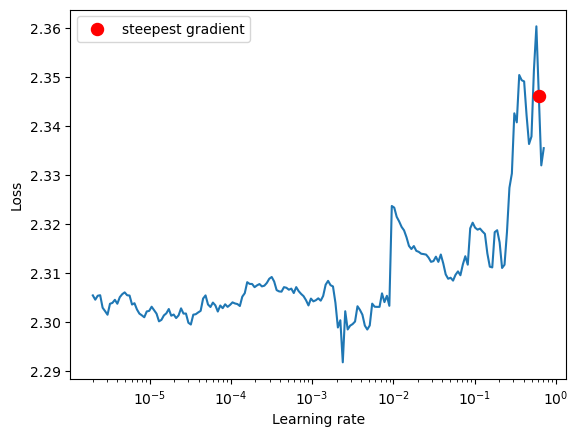

In [14]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch_lr_finder import LRFinder

optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader, start_lr = 1e-6, end_lr=1, num_iter=200,
                     accumulation_steps=ACCUM_STEPS)
lr_finder.plot()
lr_finder.reset()



  0%|          | 0/100 [00:00<?, ?it/s]

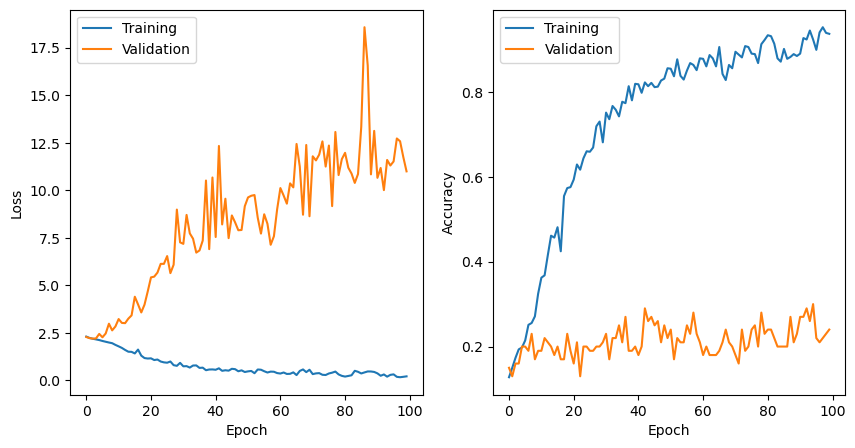

In [19]:
lr = 1e-4
n_epochs = 100


def val_step(batch):
    with torch.inference_mode():
        val_outputs = model(batch[0])
        val_loss = criterion(val_outputs, batch[1].to(DEVICE))
    return val_outputs, val_loss

def train_val_loop(n_epochs, grad_accum=None, save_every=None):
    metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }
    for i in tqdm(range(n_epochs)):
        train_loss = 0
        train_acc = 0
        model.train()
        for j, batch in enumerate(train_loader):
            if grad_accum is not None and j % grad_accum == 0:
                optimizer.zero_grad()
            outputs = model(batch[0])
            loss = criterion(outputs, batch[1].to(DEVICE))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += sum(torch.argmax(outputs.detach().cpu(), dim=1)
                             == batch[1]).item()
        train_loss /= len(train_loader)
        train_acc /= len(train_loader.dataset)
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        
        model.eval()
        val_loss = 0
        val_acc = 0
        for batch in val_loader:
            outputs, loss = val_step(batch)
            val_loss += loss.item()
            val_acc += sum(torch.argmax(outputs.detach().cpu(), dim=1)
                             == batch[1]).item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        metrics["val_loss"].append(val_loss)
        metrics["val_acc"].append(val_acc)
        
        if save_every is not None and (i+1) % save_every == 0:
            torch.save(model.state_dict(), f"../trained_models/Hubert-frozen-epoch-{i+1}.pth")
        
    return metrics

metrics = train_val_loop(n_epochs, grad_accum=2, save_every=5)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(np.arange(n_epochs), metrics["train_loss"], label="Training")
plt.plot(np.arange(n_epochs), metrics["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();
plt.subplot(122)
plt.plot(np.arange(n_epochs), metrics["train_acc"], label="Training")
plt.plot(np.arange(n_epochs), metrics["val_acc"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend();

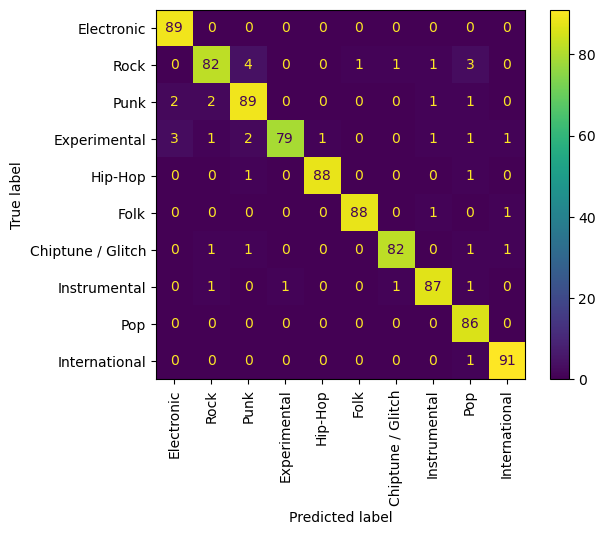

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
model.eval()
y_pred = np.zeros((len(train_loader), BATCH_SIZE))
y_true = np.zeros((len(train_loader), BATCH_SIZE))
for i, batch in enumerate(train_loader):
    with torch.inference_mode():
        logits = model(batch[0])
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred[i, :len(preds)] = preds
    labels = batch[1].numpy()
    y_true[i, :len(labels)] = labels
y_pred = y_pred.flatten()
y_true = y_true.flatten()

labels = [id2label[i] for i in range(10)]
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels,
                                        xticks_rotation='vertical')


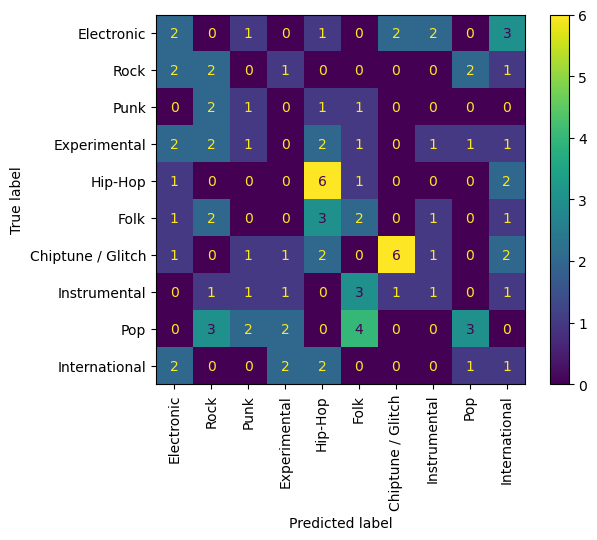

In [23]:
y_pred = np.zeros((len(val_loader), BATCH_SIZE))
y_true = np.zeros((len(val_loader), BATCH_SIZE))
for i, batch in enumerate(val_loader):
    with torch.inference_mode():
        logits = model(batch[0])
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred[i, :len(preds)] = preds
    labels = batch[1].numpy()
    y_true[i, :len(labels)] = labels
y_pred = y_pred.flatten()
y_true = y_true.flatten()

labels = [id2label[i] for i in range(10)]
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels,
                                        xticks_rotation='vertical')

In [37]:

from torch import nn
from torchaudio.pipelines import HUBERT_BASE

class HubertWrapper(nn.Module):
    def __init__(self, frozen=True):
        super().__init__()
        self.hubert = HUBERT_BASE.get_model()
        if frozen:
            # Freeze all parameters except those in the linear layer
            for param in self.hubert.feature_extractor.parameters():
                param.requires_grad = False
            for param in self.hubert.encoder.parameters():
                param.requires_grad = False
        self.conv = nn.Sequential(
            # nn.Conv1d(in_channels=768, out_channels=100, kernel_size=3, stride=3),
            # nn.ReLU(),
            # nn.Conv1d(in_channels=100, out_channels=10, kernel_size=3, stride=3),
            # nn.ReLU(),
            nn.AvgPool1d(kernel_size=1498)
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(768, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )
            
            
    def forward(self, batch):
        waveforms, lengths = batch
        encoded, _ = self.hubert(waveforms.to(DEVICE), lengths.to(DEVICE))  # [batch, chunks, classes]
        return self.linear(self.conv(encoded.permute((0, 2, 1))))

model = HubertWrapper().to(DEVICE)
summary(model, input_data=(a_batch[0],),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
HubertWrapper                                                [4, 479626]               [4, 10]                   --                        Partial
├─Wav2Vec2Model: 1-1                                         [4, 479626]               [4, 1498, 768]            --                        False
│    └─FeatureExtractor: 2-1                                 [4, 479626]               [4, 1498, 512]            --                        False
│    │    └─ModuleList: 3-1                                  --                        --                        (4,200,448)               False
│    └─Encoder: 2-2                                          [4, 1498, 512]            [4, 1498, 768]            --                        False
│    │    └─FeatureProjection: 3-2                           [4, 1498, 512]            [4, 1498, 768]            (395,008)  

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.71E-02


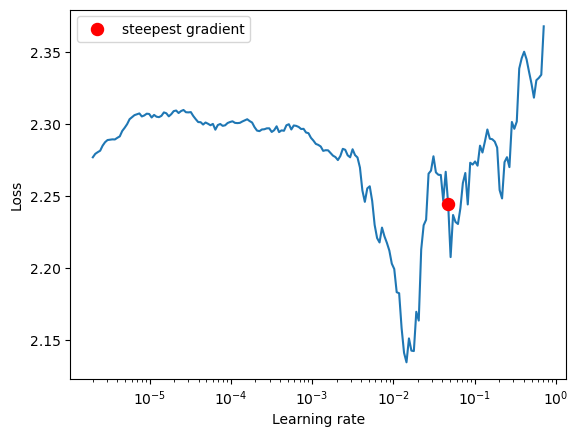

In [38]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch_lr_finder import LRFinder

optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader, start_lr = 1e-6, end_lr=1, num_iter=200,
                     accumulation_steps=ACCUM_STEPS)
lr_finder.plot()
lr_finder.reset()


  0%|          | 0/100 [00:00<?, ?it/s]

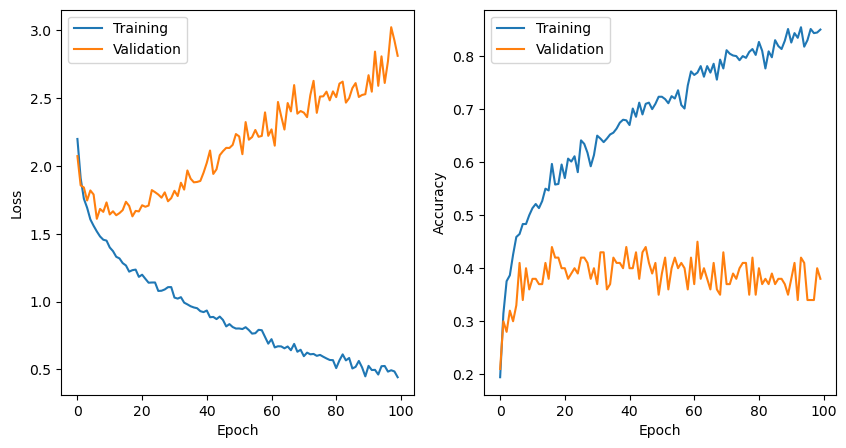

In [39]:
lr = 3e-3
n_epochs = 100


def val_step(batch):
    with torch.inference_mode():
        val_outputs = model(batch[0])
        val_loss = criterion(val_outputs, batch[1].to(DEVICE))
    return val_outputs, val_loss

def train_val_loop(n_epochs, grad_accum=None, save_every=None):
    metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }
    for i in tqdm(range(n_epochs)):
        train_loss = 0
        train_acc = 0
        model.train()
        for j, batch in enumerate(train_loader):
            if grad_accum is not None and j % grad_accum == 0:
                optimizer.zero_grad()
            outputs = model(batch[0])
            loss = criterion(outputs, batch[1].to(DEVICE))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += sum(torch.argmax(outputs.detach().cpu(), dim=1)
                             == batch[1]).item()
        train_loss /= len(train_loader)
        train_acc /= len(train_loader.dataset)
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        
        model.eval()
        val_loss = 0
        val_acc = 0
        for batch in val_loader:
            outputs, loss = val_step(batch)
            val_loss += loss.item()
            val_acc += sum(torch.argmax(outputs.detach().cpu(), dim=1)
                             == batch[1]).item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        metrics["val_loss"].append(val_loss)
        metrics["val_acc"].append(val_acc)
        
        if save_every is not None and (i+1) % save_every == 0:
            torch.save(model.state_dict(), f"../trained_models/Hubert-frozen-2layer-classifier-epoch-{i+1}.pth")
        
    return metrics

metrics = train_val_loop(n_epochs, grad_accum=2, save_every=5)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(np.arange(n_epochs), metrics["train_loss"], label="Training")
plt.plot(np.arange(n_epochs), metrics["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();
plt.subplot(122)
plt.plot(np.arange(n_epochs), metrics["train_acc"], label="Training")
plt.plot(np.arange(n_epochs), metrics["val_acc"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend();